In [11]:
from keras.models import load_model
from metrics import Pearson
from utils import prepare_data
import tensorflow_probability as tfp
from metrics import pearson, Pearson
import tensorflow as tf
import numpy as np
from dataloaders import GeneDataLoader
from utils import prepare_data, set_variables
from models import CNN
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Nadam
from keras.losses import KLDivergence, CategoricalCrossentropy
from plotting import plot_line_graph, multiplot_pearson
from utils import prepare_data, set_variables
from metrics import pearson, Pearson
from models import CNN
from plotting import box_plot
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
     

In [12]:
train_data, valid_data, test_data = prepare_data()

In [13]:

max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()
model_name = "CNN_Baseline_4Conv_Struct_ext_no_struct" # "steve_CNN_Att10" #'CNN_architecture7'
model_architecture_path, model_output_path, params_dataLoader_train, params_dataLoader_valid, params_model, params_train = set_variables(model_name, max_seq_len)

 

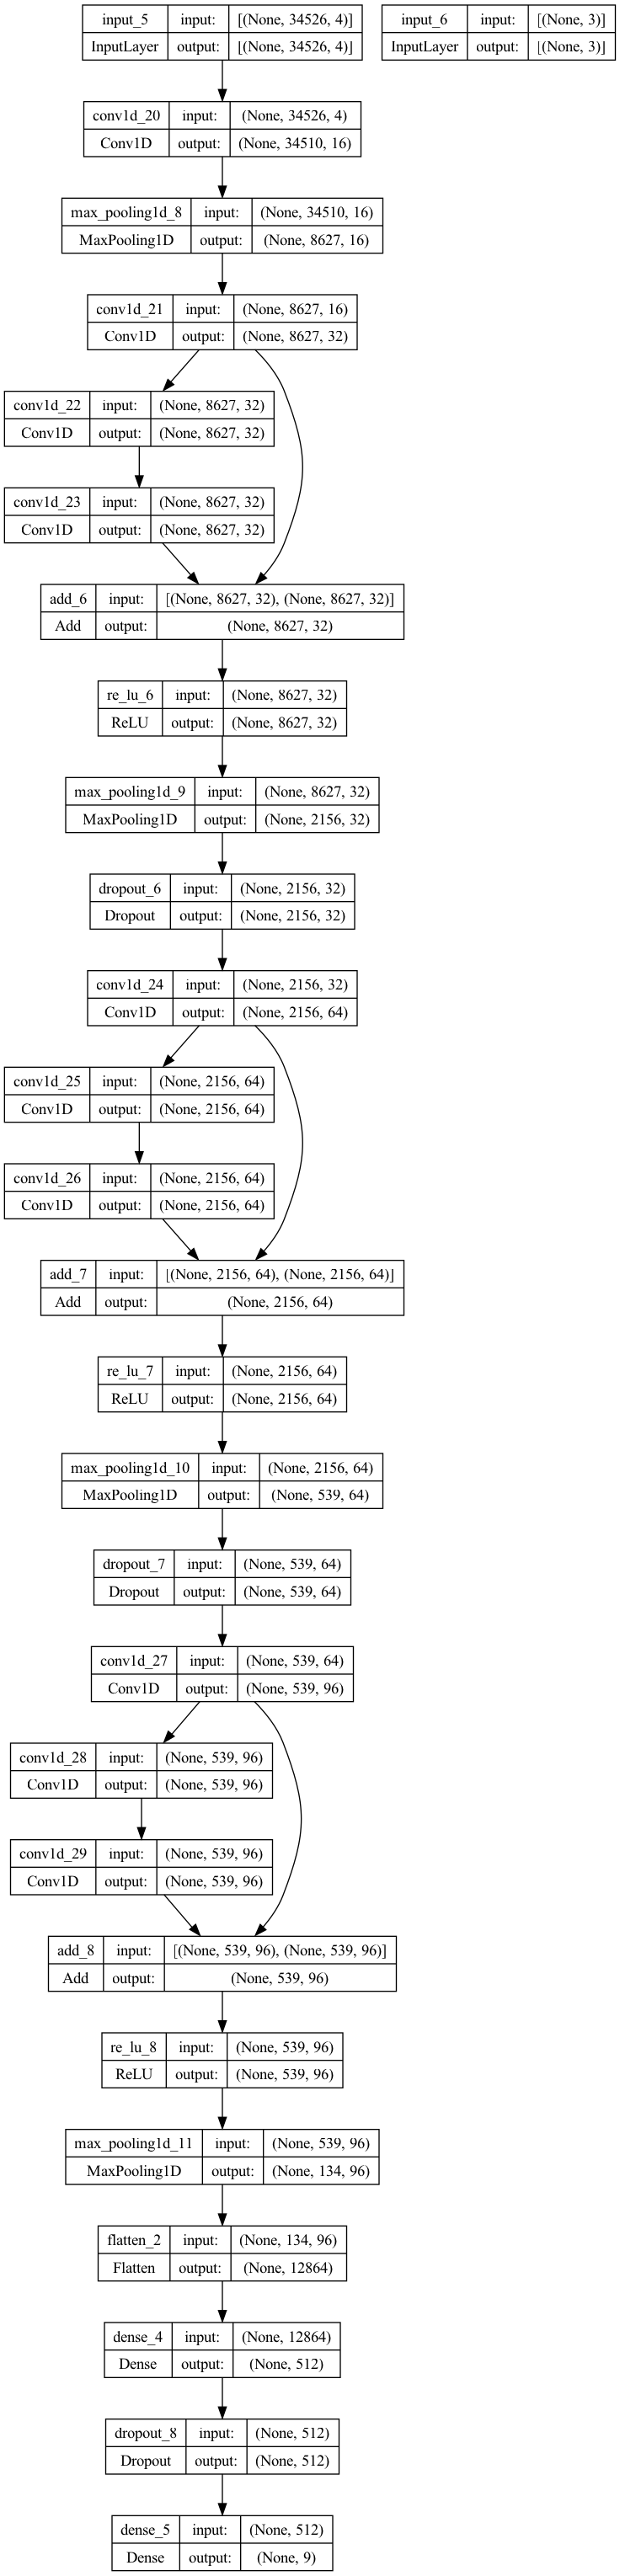

In [16]:


model = CNN(input_size=(max_seq_len, 4),
            params_model=params_model,
            optimizer=Nadam(),
            #loss=correlation_coefficient_loss, #KLDivergence(),
            metrics=[pearson, Pearson(name="class_pearson", return_dict=True),  Pearson(name="class_nodict_pearson", return_dict=False), KLDivergence(name="kullback_leibler_divergence"), "accuracy"],
            )
model.print_model()

In [17]:

path = "/Users/jonasflor/Downloads/CNN_Baseline_4Conv_Struct_ext_no_struct_2023-07-17.h5"
model.load_weights(path)

In [20]:

dataloader = GeneDataLoader(test_data, padding_length=train_data['seq'].apply(lambda x: len(x)).max(), shuffle=False, struct=False)

prediction = []
y_test = []

for i, j in dataloader:
    prediction.append(model.model.predict(i))
    y_test.append(j)

prediction = np.concatenate(prediction)
y_test = np.concatenate(y_test)

1/1 [==============================] - 0s 117ms/step


In [21]:
def pearson_dict(y_true, y_pred):
    y_true_std = tfp.stats.stddev(y_true, sample_axis=0, keepdims=True)
    y_pred_std = tfp.stats.stddev(y_pred, sample_axis=0, keepdims=True)
    
    y_true /= (y_true_std + 1e-3)
    y_pred /= (y_pred_std + 1e-3)
    
    result = tfp.stats.covariance(x=y_true,
                                y=y_pred,
                                event_axis=None,
                                sample_axis=0,
                                keepdims=False)
    res_dict = {}
    res_dict['ERM'] = result[0]
    res_dict['KDEL'] = result[1]
    res_dict['LMA'] = result[2]
    res_dict['MITO'] = result[3]
    res_dict['NES'] = result[4]
    res_dict['NIK'] = result[5]
    res_dict['NLS'] = result[6]
    res_dict['NUCP'] = result[7]
    res_dict['OMM'] = result[8]
    return res_dict

In [22]:
pearson_dict(y_test, prediction)

{'ERM': <tf.Tensor: shape=(), dtype=float32, numpy=0.29293206>,
 'KDEL': <tf.Tensor: shape=(), dtype=float32, numpy=0.33646473>,
 'LMA': <tf.Tensor: shape=(), dtype=float32, numpy=0.05843937>,
 'MITO': <tf.Tensor: shape=(), dtype=float32, numpy=0.12394447>,
 'NES': <tf.Tensor: shape=(), dtype=float32, numpy=0.1757214>,
 'NIK': <tf.Tensor: shape=(), dtype=float32, numpy=0.1701633>,
 'NLS': <tf.Tensor: shape=(), dtype=float32, numpy=0.1770662>,
 'NUCP': <tf.Tensor: shape=(), dtype=float32, numpy=0.1790481>,
 'OMM': <tf.Tensor: shape=(), dtype=float32, numpy=0.09581416>}

In [23]:
np.mean(list(pearson_dict(y_test, prediction).values()))

0.17884375